# Traducción de texto mediante algoritmos de Machine learning

María Ruiz de Castroviejo y Sergio Rincón

### Importación de las librerías

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Lectura de datos

Los datos son un archivo de texto de pares de oraciones en inglés-español.

In [2]:
# Leemos el archivo
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Ahora definamos una función para dividir el texto en pares inglés-español separados por '\ n'. Luego dividimos estos pares en oraciones de inglés y español.

In [3]:
# Dividimos en frases
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

Para descargar los datos pulse [aquí.](http://www.manythings.org/anki/deu-eng.zip)__ y extrae "spa.txt" en tu directorio de trabajo.

In [4]:
data = read_text("C:/Users/María/MASTER/Datos No Estruct/Texto/Practica/data/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

Los datos contienen más de 150 mil pares de oraciones. Sin embargo, usaremos los primeros 50 mil pares de oraciones para reducir el tiempo de entrenamiento del modelo.

In [5]:
spa_eng = spa_eng[:50000,:]

In [6]:
spa_eng.shape

(50000, 3)

### Limpieza de texto

Echemos un vistazo a nuestros datos:

In [7]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest.', 'Agradezco tu interés.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

Eliminaremos los signos de puntuación y luego convertiremos el texto a minúsculas.

In [8]:
# Eliminamos los signos de puntuación 
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [9]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest', 'Agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [10]:
# Convertimos el texto a minúsculas
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [11]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['i appreciate all your help', 'aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['i appreciate your interest', 'agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

### Preprocesamiento de texto

- #### Conversión de texto a secuencia

Para alimentar nuestros datos en un modelo *Seq2Seq*, tendremos que convertir las oraciones de entrada y de salida en secuencias enteras de longitud fija. Antes de eso, visualizamos la longitud de las oraciones en dos listas separadas para inglés y para español, respectivamente.

In [12]:
# Listas vacias
eng_l = []
spa_l = []

# Rellenar las listas con longitudes de oraciones
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'Inglés':eng_l, 'Español':spa_l})
print(length_df)
print(max(length_df.Inglés))
print(max(length_df.Español))

       Inglés  Español
0           1        1
1           1        1
2           1        1
3           1        1
4           1        1
...       ...      ...
49995       6        5
49996       8        6
49997       6        5
49998       5        4
49999       4        3

[50000 rows x 2 columns]
8
12


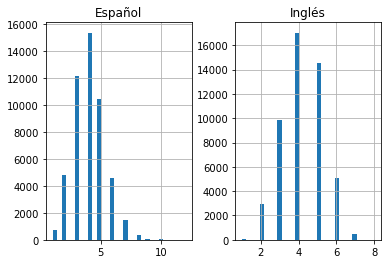

In [14]:
length_df.hist(bins = 30)
plt.show()

La longitud máxima de las frases en Español es de 10 y la de las frases en Inglés es de 7.

- #### Tokenización

A continuación, necesitamos tokenizar los datos, es decir, convertir el texto en valores numéricos. Esto permite que la red neuronal realice operaciones sobre los datos de entrada. 

Vectoricemos nuestros datos de texto usando la clase *Tokenizer ()* de Keras. Convertirá nuestras oraciones en secuencias de números enteros. Luego rellenaremos esas secuencias con ceros para hacer que todas las secuencias tengan la misma longitud.

In [15]:
# Función para construir un tokenizador
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# Preparar tokenizador en inglés
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('Tamaño del vocabulario en inglés: %d' % eng_vocab_size)

Tamaño del vocabulario en inglés: 6942


In [17]:
# Preparar tokenizador en español
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Tamaño del vocabulario en español: %d' % spa_vocab_size)

Tamaño del vocabulario en español: 14196


In [18]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 115), ('vete', 30), ('vaya', 41), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 380), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('corrí', 13), ('corría', 4), ('lo', 2116), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5878), ('tomátelo', 2), ('con', 871), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 489), ('mismo', 129), ('id', 6), ('vayan', 11), ('ya', 339), ('¡lo', 10), ('tengo', 876), ('¿lo', 63), ('pillas', 1), ('¿entendiste', 2), ('él', 2559), ('corrió', 23), ('métete', 3), ('adentro', 26), ('abráz

A continuación se muestra una función para preparar las secuencias. También realizará el relleno de secuencia hasta su longitud máxima.

Cuando introducimos nuestras secuencias de ID de palabras en el modelo, cada secuencia debe tener la misma longitud. Para lograr esto, se agrega relleno a cualquier secuencia que sea más corta que la longitud máxima (es decir, más corta que la oración más larga).

In [19]:
# Codificar y rellenar secuencias
def encode_sequences(tokenizer, length, lines):
    # Secuencias de codificación entera
    seq = tokenizer.texts_to_sequences(lines)
    # Rellenar las secuencias con 0
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

eng_padding= encode_sequences(eng_tokenizer, 12, spa_eng[:, 0])

### Creación de la muestra de train y test

Dividimos los datos para el entrenamiento y la evaluación del modelo.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

Codificamos las oraciones de español como secuencias de entrada y las oraciones de inglés como secuencias de destino. Para el conjunto de train y test.

In [21]:
# Preparación de los datos de entrenamiento
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [22]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [23]:
# Preparación de los datos de test
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [24]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


### Construcción del modelo

Partes de la arquitectura de un RNN en un nivel alto:

- **Entradas.** Las secuencias de entrada se introducen en el modelo con una palabra para cada paso de tiempo. Cada palabra está codificada como un número entero único o un vector codificado en caliente que se asigna al vocabulario del conjunto de datos en inglés.


- **Embeddings.** Las incrustaciones se utilizan para convertir cada palabra en un vector. El tamaño del vector depende de la complejidad del vocabulario.


- **Capas recurrentes (codificador).** Aquí es donde el contexto de los vectores de palabras en los pasos de tiempo anteriores se aplica al vector de palabras actual.


- **Capas densas (decodificador).** Estas son capas típicas completamente conectadas que se utilizan para decodificar la entrada codificada en la secuencia de traducción correcta.


- **Salidas.** Las salidas se devuelven como una secuencia de números enteros o vectores codificados en caliente que luego se pueden asignar al vocabulario del conjunto de datos.

Los **Embeddings** permiten capturar relaciones de palabras sintácticas y semánticas más precisas proyectando cada palabra en un espacio n-dimensional. Las palabras con significados similares ocupan regiones similares de este espacio; cuanto más cercanas están dos palabras, más similares son. Y a menudo los vectores entre palabras representan relaciones útiles, como género, tiempo verbal o incluso relaciones geopolíticas.

El entrenamiento con Embeddings en un gran conjunto de datos desde cero requiere una gran cantidad de datos y cálculos. Entonces, en lugar de hacerlo nosotros mismos, normalmente usamos un paquete de Embeddings previamente entrenado como word2vec . Cuando se usan de esta manera, las incrustaciones son una forma de aprendizaje por transferencia. Sin embargo, dado que nuestro conjunto de datos para este proyecto tiene un vocabulario pequeño y poca variación sintáctica, usaremos Keras para entrenar las incrustaciones nosotros mismos.

Nuestro **modelo secuencia a secuencia** vincula dos redes recurrentes: un codificador y un descodificador. El codificador resume la entrada en una variable de contexto. Depués, se decodifica este contexto y se genera la secuencia de salida. Dado que tanto el codificador como el descodificador son recurrentes, tienen bucles que procesan cada parte de la secuencia en diferentes pasos de tiempo. 

Para cada paso de tiempo después de la primera palabra en la secuencia hay dos entradas: el estado oculto y una palabra de la secuencia. Para el codificador, es la siguiente palabra en la secuencia de entrada. Para el decodificador, es la palabra anterior de la secuencia de salida.

El aprendizaje secuencia a secuencia (Seq2Seq) se trata de entrenar modelos para convertir secuencias de un dominio (inglés) a secuencias en otro dominio (español). Es útil para la generación de texto como traducción automática y respuesta a preguntas. Definimos la arquitectura *Seq2Seq*. Estamos usando una capa de incrustación y una capa LSTM como codificador y otra capa LSTM seguida de una capa densa como decodificador.

Ya entendemos cómo fluye el contexto a través de la red a través del estado oculto, elsiguiente paso es entender como fluye el contexto en ambas direcciones. Esto es lo que hace una **capa bidireccional**. Proporcionar un contexto futuro puede resultar en un mejor rendimiento del modelo. 

Esto puede parecer contrario a la forma en que los humanos procesan el lenguaje, ya que solo leemos en una dirección. Sin embargo, los humanos a menudo requieren un contexto futuro para interpretar lo que se dice. En otras palabras, a veces no entendemos una oración hasta que se proporciona una palabra o frase importante al final. Para implementar esto, entrenamos dos capas RNN simultáneamente. La primera capa se alimenta con la secuencia de entrada tal cual y la segunda se alimenta con una copia invertida.

In [25]:
# Modelo LSTM
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [26]:
# Modelo RNN
def build_model_rnn(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))       
      
    return model

In [27]:
# Modelo GRU
def build_model_gru(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units, return_sequences=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(Dense(out_vocab, activation='softmax'))
    
    return model

Usamos el optimizador __'RMSprop (Root Mean Square Propagation)'__ ya que suele ser una buena opción para redes neuronales recurrentes. Otros tipos de optimizadores de redes neuronales profundas: Stochastic Gradient Descent (SGD), Adaptive Gradient Algorithm (AdaGrad), Adam (Adaptive moment estimation)...

Como función de pérdida hemos utilizado __'sparse_categorical_crossentropy'__ porque nos permite usar la secuencia de destino tal y como está, en lugar de un formato codificado en caliente. Una codificación en caliente de las secuencias de destino con un vocabulario tan grande podría consumir toda la memoria de nuestro sistema. Otros tipos de funciones de pérdida: CategoricalCrossentropy, BinaryCrossentropy.

Podemos comenzar a entrenar nuestro modelo. Lo entrenaremos durante 30 épocas, con un tamaño de lote de 512. También usaremos __ModelCheckpoint ()__ para guardar el mejor modelo con la menor pérdida de test. Este método sirve para evitar la parada anticipada.

In [28]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms =   optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [29]:
model2 = build_model_rnn(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms =    optimizers.RMSprop(lr=0.001)
model2.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [30]:
model3 = build_model_gru(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms =    optimizers.RMSprop(lr=0.001)                                       # Defining the optimizing function
model3.compile(optimizer=rms, loss='sparse_categorical_crossentropy')       # Configuring the model for training

A veces es útil apilar varias capas recurrentes una tras otra para aumentar el poder de representación de una red. Se deben obtener todas las capas intermedias para devolver secuencias completas.

Más detalles sobre RepeatVector: https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/ Si se intenta forzar estas piezas del codificador-decodificador juntas, seobtiene un error que indica que la salida del decodificador es 2D y se requiere entrada 3D para el decodificador.

Podemos resolver esto usando una capa *RepeatVector* que simplemente repite la entrada 2D proporcionada varias veces para crear una salida 3D. La capa *RepeatVector* se puede utilizar como un adaptador para ajustar el codificador y el decodificador de la red juntos. Podemos configurarlo para que repita el vector de longitud fija en cada paso de tiempo en la secuencia de salida.

En resumen, el *RepeatVector* se utiliza como un **adaptador para ajustar la salida 2D de tamaño fijo del codificador a las diferentes longitudes y entradas 3D esperadas por el decodificador**. El contenedor *TimeDistributed* permite reutilizar la misma capa de salida para cada elemento en la secuencia de salida.

In [ ]:
# DO NOT RUN IT (example of RepeatVector)
model = Sequential()
model.add(Dense(32, input_dim=32))

# now: model.output_shape == (None, 32)
# note: `None` is the batch dimension
model.add(RepeatVector(3))

# now: model.output_shape == (None, 3, 32)

En el ejemplo anterior, la capa *RepeatVector* repite las entradas entrantes un número específico de tiempo. La forma de la entrada anterior era (32,). Pero la forma de salida del *RepeatVector* fue (3, 32), ya que las entradas se repitieron 3 veces.

In [31]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14196
6942
8
8


- **LSTM**

La capa SimpleRNN no es bueno al procesar secuencias largas, como texto. Esto se debe al problema del gradiente de desaparición. Otros tipos de capas recurrentes funcionan mucho mejor como LSTM Y GRU.

**Long Short Term Memory o memoria a corto plazo (LSTM)** es una variante de la capa SimpleRNN que ya lleva información en muchos pasos de tiempo. Guarda la información para más tarde, evitando así que las señales más antiguas desaparezcan durante el procesamiento. Las unidades de memoria en un LSTM aprenden qué recordar y además pueden memorizar datos anteriores fácilmente.

In [35]:
filename = 'model.h1.LSTM'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, 
          batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 71s 1s/step - loss: 4.9653 - val_loss: 4.0429
Epoch 2/30
63/63 [==============================] - 78s 1s/step - loss: 3.8995 - val_loss: 3.8727
Epoch 3/30
63/63 [==============================] - 93s 1s/step - loss: 3.7720 - val_loss: 3.7566
Epoch 4/30
63/63 [==============================] - 96s 2s/step - loss: 3.6203 - val_loss: 3.6361
Epoch 5/30
63/63 [==============================] - 90s 1s/step - loss: 3.4642 - val_loss: 3.4968
Epoch 6/30
63/63 [==============================] - 86s 1s/step - loss: 3.3091 - val_loss: 3.3790
Epoch 7/30
63/63 [==============================] - 89s 1s/step - loss: 3.1644 - val_loss: 3.2711
Epoch 8/30
63/63 [==============================] - 94s 1s/step - loss: 3.0185 - val_loss: 3.2071
Epoch 9/30
63/63 [==============================] - 91s 1s/step - loss: 2.9031 - val_loss: 3.1249
Epoch 10/30
63/63 [==============================] - 91s 1s/step - loss: 2.7899 - val_loss: 3.0656
Epoch 11/30
63/63 [

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            7268352   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 6942)           3561246   
Total params: 15,027,998
Trainable params: 15,027,998
Non-trainable params: 0
_________________________________________________________________


Comparamos la función de pérdida de train y test.

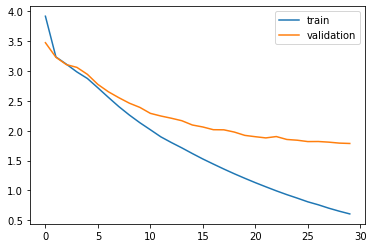

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

- **RNN**

**Recurrent Neural Networks o redes neuronales recurrentes (RNN)** son un tipo de red neuronal donde la salida del paso anterior se alimenta como entrada al paso actual. El estado oculto  recuerda alguna información sobre una secuencia. Los RNN tienen una “memoria” que recuerda TODA la información sobre lo calculado. Utiliza los mismos parámetros para cada entrada, ya que realiza la misma tarea en todas las entradas para producir la salida. Esto reduce la complejidad de los parámetros.

In [28]:
filename = 'model.h1.RNN'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history2 = model2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                     epochs=20,
                     batch_size=128,
                     validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 67s 265ms/step - loss: 3.7829 - val_loss: 2.9785
Epoch 2/20
250/250 [==============================] - 81s 325ms/step - loss: 2.8828 - val_loss: 2.6685
Epoch 3/20
250/250 [==============================] - 85s 340ms/step - loss: 2.5266 - val_loss: 2.4209
Epoch 4/20
250/250 [==============================] - 87s 347ms/step - loss: 2.1907 - val_loss: 2.2195
Epoch 5/20
250/250 [==============================] - 83s 332ms/step - loss: 1.9498 - val_loss: 2.0984
Epoch 6/20
250/250 [==============================] - 81s 325ms/step - loss: 1.7582 - val_loss: 1.9998
Epoch 7/20
250/250 [==============================] - 82s 330ms/step - loss: 1.5825 - val_loss: 1.9228
Epoch 8/20
250/250 [==============================] - 83s 333ms/step - loss: 1.4407 - val_loss: 1.8659
Epoch 9/20
250/250 [==============================] - 81s 326ms/step - loss: 1.3208 - val_loss: 1.8440
Epoch 10/20
250/250 [==============================] - 81s 325ms/step - l

In [29]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            7268352   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 512)               524800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8, 512)            524800    
_________________________________________________________________
dense (Dense)                (None, 8, 6942)           3561246   
Total params: 11,879,198
Trainable params: 11,879,198
Non-trainable params: 0
_________________________________________________________________


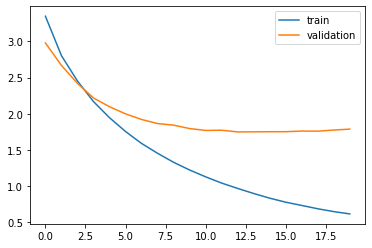

In [30]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

- **GRU**

**Gated recurrent units o unidades recurrentes cerradas (GRUs)** son un mecanismo de compuerta en las redes neuronales recurrentes. El GRU es como una memoria a corto plazo (LSTM) PERO con  menos parámetros. LSTM tiene tres puertas (entrada, salida y puerta de olvido) y GRU tiene dos puertas (puerta de reinicio y actualización). 

La puerta de actualización (z) ayuda al modelo a determinar cuánta información de los pasos de tiempo anteriores debe transmitirse al futuro. Mientras tanto, la puerta de reinicio (r) decide cuánta información pasada se debe olvidar. Hace que las RNN sean un poco más inteligentes. En lugar de permitir que toda la información del estado oculto fluya a través de la red, tenemos que ser más selectivos con la información sea más relevante. 

LSTM es más preciso en los conjuntos de datos que utilizan una secuencia más larga pero GRU usa menos parámetros de entrenamiento y por lo tanto usa menos memoria; se ejecuta más rápido que LSTM. En resumen, si la secuencia es grande o la precisión es muy crítica,es mejor usar LSTM pero si queremos una operación más rápida y que use menos memoria optaremos GRU.

In [28]:
filename = 'model.h1.GRU'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history3 = model3.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, 
          batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 78s 1s/step - loss: 4.4538 - val_loss: 3.3677

Epoch 00001: val_loss improved from inf to 3.36766, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 2/30
63/63 [==============================] - 91s 1s/step - loss: 3.2988 - val_loss: 3.2014

Epoch 00002: val_loss improved from 3.36766 to 3.20140, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 3/30
63/63 [==============================] - 95s 2s/step - loss: 3.1050 - val_loss: 3.0889

Epoch 00003: val_loss improved from 3.20140 to 3.08895, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 4/30
63/63 [==============================] - 96s 2s/step - loss: 2.9494 - val_loss: 3.0073

Epoch 00004: val_loss improved from 3.08895 to 3.00729, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 5/30
63/63 [==============================] - 97s 2s/step - loss: 2.8579 - val_loss: 2.9073

Epoch 00005: val_loss improved from 3.00729 to 2.90729, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 6/30
63/63 [==============================] - 94s 2s/step - loss: 2.7268 - val_loss: 2.7973

Epoch 00006: val_loss improved from 2.90729 to 2.79726, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 7/30
63/63 [==============================] - 98s 2s/step - loss: 2.5891 - val_loss: 2.6646

Epoch 00007: val_loss improved from 2.79726 to 2.66457, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 8/30
63/63 [==============================] - 96s 2s/step - loss: 2.4337 - val_loss: 2.5831

Epoch 00008: val_loss improved from 2.66457 to 2.58310, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 9/30
63/63 [==============================] - 96s 2s/step - loss: 2.2901 - val_loss: 2.4588

Epoch 00009: val_loss improved from 2.58310 to 2.45883, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 10/30
63/63 [==============================] - 96s 2s/step - loss: 2.1563 - val_loss: 2.4047

Epoch 00010: val_loss improved from 2.45883 to 2.40469, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 11/30
63/63 [==============================] - 97s 2s/step - loss: 2.0361 - val_loss: 2.3318

Epoch 00011: val_loss improved from 2.40469 to 2.33180, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 12/30
63/63 [==============================] - 96s 2s/step - loss: 1.9328 - val_loss: 2.2647

Epoch 00012: val_loss improved from 2.33180 to 2.26472, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 13/30
63/63 [==============================] - 99s 2s/step - loss: 1.8213 - val_loss: 2.2307

Epoch 00013: val_loss improved from 2.26472 to 2.23070, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 14/30
63/63 [==============================] - 99s 2s/step - loss: 1.7187 - val_loss: 2.1533

Epoch 00014: val_loss improved from 2.23070 to 2.15333, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 15/30
63/63 [==============================] - 102s 2s/step - loss: 1.6272 - val_loss: 2.1256

Epoch 00015: val_loss improved from 2.15333 to 2.12559, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 16/30
63/63 [==============================] - 98s 2s/step - loss: 1.5239 - val_loss: 2.0797

Epoch 00016: val_loss improved from 2.12559 to 2.07971, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 17/30
63/63 [==============================] - 101s 2s/step - loss: 1.4344 - val_loss: 2.0602

Epoch 00017: val_loss improved from 2.07971 to 2.06018, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 18/30
63/63 [==============================] - 98s 2s/step - loss: 1.3545 - val_loss: 2.0000

Epoch 00018: val_loss improved from 2.06018 to 2.00002, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 19/30
63/63 [==============================] - 99s 2s/step - loss: 1.2789 - val_loss: 2.0025

Epoch 00019: val_loss did not improve from 2.00002
Epoch 20/30
63/63 [==============================] - 99s 2s/step - loss: 1.1980 - val_loss: 1.9618

Epoch 00020: val_loss improved from 2.00002 to 1.96177, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 21/30
63/63 [==============================] - 101s 2s/step - loss: 1.1218 - val_loss: 1.9281

Epoch 00021: val_loss improved from 1.96177 to 1.92810, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 22/30
63/63 [==============================] - 98s 2s/step - loss: 1.0453 - val_loss: 1.9101

Epoch 00022: val_loss improved from 1.92810 to 1.91006, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 23/30
63/63 [==============================] - 96s 2s/step - loss: 0.9822 - val_loss: 1.9015

Epoch 00023: val_loss improved from 1.91006 to 1.90149, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 24/30
63/63 [==============================] - 99s 2s/step - loss: 0.9059 - val_loss: 1.8803

Epoch 00024: val_loss improved from 1.90149 to 1.88033, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 25/30
63/63 [==============================] - 97s 2s/step - loss: 0.8464 - val_loss: 1.8679

Epoch 00025: val_loss improved from 1.88033 to 1.86786, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 26/30
63/63 [==============================] - 97s 2s/step - loss: 0.7835 - val_loss: 1.8630

Epoch 00026: val_loss improved from 1.86786 to 1.86301, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 27/30
63/63 [==============================] - 99s 2s/step - loss: 0.7312 - val_loss: 1.8617

Epoch 00027: val_loss improved from 1.86301 to 1.86170, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 28/30
63/63 [==============================] - 97s 2s/step - loss: 0.6795 - val_loss: 1.8397

Epoch 00028: val_loss improved from 1.86170 to 1.83972, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 29/30
63/63 [==============================] - 102s 2s/step - loss: 0.6210 - val_loss: 1.8467

Epoch 00029: val_loss did not improve from 1.83972
Epoch 30/30
63/63 [==============================] - 99s 2s/step - loss: 0.5748 - val_loss: 1.8513

Epoch 00030: val_loss did not improve from 1.83972


In [29]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            7268352   
_________________________________________________________________
gru (GRU)                    (None, 512)               1575936   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 8, 512)            1575936   
_________________________________________________________________
dense (Dense)                (None, 8, 6942)           3561246   
Total params: 13,981,470
Trainable params: 13,981,470
Non-trainable params: 0
_________________________________________________________________


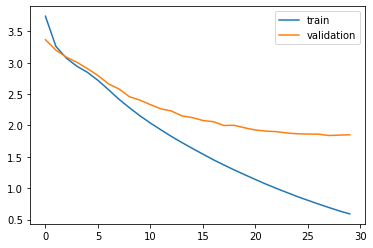

In [32]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Observando las funciones de pérdida de los tres modelos vemos que LSTM y GRU se sobre ajustan. Esto es algo normal ya que la traducción al final es muy dependiente del texto en el que está. Se comportan de forma muy parecida. 

LSTM (memoria a largo plazo) tiene tres puertas (entrada, salida y puerta de olvido), mientras que la GRU tiene dos puertas (puerta de reinicio y puerta de actualización). Las GRU asocian puertas de olvido y de entrada. Las GRU utilizan menos parámetros de entrenamiento y, por lo tanto, utilizan menos memoria, se ejecutan más rápidamente y se entrenan más rápido que las LSTM, mientras que éstas son más precisas en conjuntosde datos que utilizan una secuencia más larga (LSTM 80 min Y GRU 60 min).

En resumen, si la secuencia es grande o la precisión es muy importante, se empleanLSTMs, mientras que para un menor consumo de memoria y un funcionamiento más rápido se escogen GRUs. Cuanto menor sea la función de pérdida; mejor será el modelo. Por lo que el mejor modelo es LSTM ya se empieza a estabilizar antes. 

### Predicciones LSTM

Cargamos el modelo guardado para hacer las predicciones.

In [31]:
model = load_model('C:/Users/María/MASTER/Datos No Estruct/Texto/Practica/model.h1.LSTM')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\María\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [32]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [33]:
# Convertir las predicciones en texto (inglés)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [34]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [35]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,theyre very
1,i know tom,i know tom
2,you may refuse,you may move
3,thats private,thats is gimmick
4,tom leaped from his seat,tom is on his
5,have you ever sold a car,where did you have my car
6,how many kids do you have,how much books do you have
7,i will not let you do it,i wont not to do you
8,isnt it beautiful,is it beautiful
9,my parrot died yesterday,my mother died


In [36]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,did tom know to
9986,tom can be clumsy,tom can be
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who it is
9989,shes also a beauty,its a trap
9990,i love your daughter,i want my name
9991,he teaches english,he teaches english
9992,i overslept,i was asleep
9993,he is as poor as can be,he is as
9994,wheres my shirt,wheres my husband


In [37]:
pred_df.sample(15)

,actual,predicted
7461,she listens to him,she shouted to
5547,look here,look here
803,get some sleep,get a rest
7601,i feel cold this morning,my answer is cold
7855,tom used to be demanding,tom was very lucky
5200,i have a big black dog,i have a dog
4353,we have to surrender,we must to evacuate
5432,i know how you feel,i know how you are
6504,what was the result,what was the boy
3027,i always keep my word,i never have my word


### Predicciones RNN

In [31]:
model2 = load_model('C:/Users/María/MASTER/Datos No Estruct/Texto/Practica/model.h1.RNN')
preds = model2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\María\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [32]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [33]:
# Convertir las predicciones en texto (inglés)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [34]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [35]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,they very
1,i know tom,i know tom
2,you may refuse,you can return
3,thats private,thats is
4,tom leaped from his seat,tom held his seat
5,have you ever sold a car,have you ever a
6,how many kids do you have,how many kids do you
7,i will not let you do it,i didnt do to do
8,isnt it beautiful,isnt it beautiful
9,my parrot died yesterday,my father died fun


In [36]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,does tom im mary
9986,tom can be clumsy,tom can be true
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who he was
9989,shes also a beauty,shes a too
9990,i love your daughter,i want your daughter
9991,he teaches english,he is english
9992,i overslept,i fell asleep
9993,he is as poor as can be,he is as
9994,wheres my shirt,wheres my shirt


In [37]:
pred_df.sample(15)

,actual,predicted
8375,i accept your apologies,i accept your
9128,my dog doesnt bite,my dog is this
3510,you should be a teacher,you should be a fun
8971,hows work,how was the
3013,would you agree with that,i agree with
1650,you know the law,you know the
2978,it looks like an apple,he seems like an apple
2856,i need to go on a diet,i need to get a room
6703,you can smoke here,you can smoke
8815,dont hang up yet please,dont cant not yet


### Predicciones GRU

In [33]:
model3 = load_model('C:/Users/María/MASTER/Datos No Estruct/Texto/Practica/model.h1.GRU')
preds = model3.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\María\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [35]:
# Convertir las predicciones en texto (inglés)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [36]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [37]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,they very dangerous
1,i know tom,i know tom
2,you may refuse,you may be
3,thats private,thats terrible
4,tom leaped from his seat,tom works in his room
5,have you ever sold a car,did you have a
6,how many kids do you have,how many books do you have
7,i will not let you do it,i wont do it either
8,isnt it beautiful,isnt is beautiful
9,my parrot died yesterday,my pain was dying


In [38]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,does tom ask to
9986,tom can be clumsy,tom might be well
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who i was
9989,shes also a beauty,its a good
9990,i love your daughter,i want your opinion
9991,he teaches english,he also like rain
9992,i overslept,i went asleep
9993,he is as poor as can be,he is as and rich
9994,wheres my shirt,wheres your


In [39]:
pred_df.sample(15)

,actual,predicted
9667,is tom conscious,is tom free
2811,you were right tom,you tom right
6739,i still dont believe it,i still know believe it
8594,there has to be a way,it must be a
9356,i didnt do my homework,i didnt do my homework
4266,i know a few things,i know a of
9344,she sang happily,she smiled deeply
8199,does that window open,can i open your window
5206,tom isnt a crook,tom isnt a stranger
4319,i said you could go,i said i could go


Si comparamos a fondo las traducciones de los modelos; las traducciones de LSTM y GRU ya no se parecen tanto. 